In [1]:
import load_data
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import torch
import torch_utils
import models
import collections
from torch import optim

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

## Loading data

In [3]:
read_dir = 'data/cases_small_preprocessedLEMM/'
Y = []
X = []
min_tokens = 200
for i, (text, y) in enumerate(load_data.yield_preprocessed_json_from_disk(read_dir)):
    if len(text.split()) > min_tokens:
        Y.append(y)
        X.append(text)

        
# shuffling data to break  storage order patterns
idx = np.arange(len(X))
np.random.shuffle(idx)
X = [X[j] for j in idx]
Y = [Y[j] for j in idx]

100%|█████████████████████████████████████████████████████████████████████████████████| 113/113 [01:42<00:00,  1.11it/s]


Calculating the number of samples/number of words per sample ratio.

In [4]:
def get_num_words_per_sample(sample_texts):
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)
nwps = get_num_words_per_sample(X)
print(f'Number_of_samples/number_of_words_per_sample :: {len(X)}/{nwps} :: {len(X)/nwps}')

Number_of_samples/number_of_words_per_sample :: 130206/725.0 :: 179.5944827586207


Mapping casenumbers to categories IDs.

In [5]:
cases_info = pd.read_csv('data/cases_info.csv')
cases_d = dict(zip(cases_info['Number'], cases_info['CategoryID']))
del cases_info

Skipping indices that are not labeled. And creating a maping from categoryID to categoryIndex

In [6]:
Y_id = np.array(list(map(lambda case: cases_d[case], Y)))


skip_indices = set(np.where(Y_id == -1)[0])
keep_mask = (Y_id != -1)

id2i = dict(zip(set(Y_id[keep_mask]), range(len(set(Y_id[keep_mask])))))
i2id = {v:k for k, v in id2i.items()}

X = [x for i, x in enumerate(X) if i not in skip_indices]
Y = [y for i, y in enumerate(Y) if i not in skip_indices]
Y_id = [y_id for i, y_id in enumerate(Y_id) if i not in skip_indices]

Y_idx = np.array(list(map(lambda y_id: id2i[y_id], Y_id)))

Spliting indices into train and test

In [7]:
np.random.seed(0)
DS_SIZE = len(Y_idx)
TEST_SIZE = .2
indices = np.arange(DS_SIZE)
train_indices, test_indices = train_test_split(indices, test_size=TEST_SIZE, stratify=Y_idx)

In [8]:
X_train_list = []
X_test_list = []
for train_idx in train_indices:
    X_train_list.append(X[train_idx])
for test_idx in test_indices:
    X_test_list.append(X[test_idx])

Vectorizing and cho

In [9]:
vectorizer = TfidfVectorizer(
#     input='filename',
    ngram_range=(1, 2),
#     max_df=.95, 
#     min_df=.001,
#     tokenizer=None
                            )
# # max_df :: # ignoring terms that occur more then in {max_df} % documents (or categories)
# # min_df :: # ignoring terms that occur less then in {min_df} % documents (or categories)
# filelist = sorted(
#     glob.glob('temp_data/train_corpusSMALL_LEMM/*'), 
#     key=lambda x: int(x.split('/')[-1].split('.')[0])
# )

# filelist[:3]

approx_K = 20 * 10**3
K = 2**(np.int(np.log2(approx_K)))
print(f"K :: {K},  power :: {np.int(np.log2(approx_K))}")
selector = SelectKBest(f_classif, k=K)


import time
start = time.time()
# vectorizer.fit(X)
S_train = vectorizer.fit_transform(X_train_list)
# S_train = vectorizer.transform(X_train_list)
S_test = vectorizer.transform(X_test_list)
selector.fit(S_train, Y_idx[train_indices])
S_train = selector.transform(S_train).astype('float32')
S_test = selector.transform(S_test).astype('float32')
end = time.time()
print(f'APPROX FIT TIME (s):: {round(end - start)}')

K :: 16384,  power :: 14
APPROX FIT TIME (s):: 119


In [10]:
from torch.utils.data import TensorDataset, DataLoader

In [13]:
N_splits_train = 12
N_splits_test = int(N_splits_train * TEST_SIZE)

X_train, X_test = S_train, S_test

Y_idx_t = torch.Tensor(Y_idx).type(torch.long)
Y_train, Y_test = Y_idx_t[train_indices], Y_idx_t[test_indices]

train_sl = torch_utils.SplitLoader(X_train, Y_train, N_splits_train, "temp_tensors/train")
train_sl.split_and_save()
test_sl = torch_utils.SplitLoader(X_test, Y_test, N_splits_test, "temp_tensors/test")
test_sl.split_and_save()

In [44]:
INPUT_DIM = X_train.shape[-1]
print(f'INPUT_DIM : {INPUT_DIM}')
OUTPUT_DIM = len(np.unique(Y_idx))  # _classes
print(f'OUTPUT_DIM : {OUTPUT_DIM}')

BATCH_SIZE = 2**6
print(f'BATCH_SIZE : {BATCH_SIZE}')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
model = models.MLP2(INPUT_DIM, OUTPUT_DIM, layer_dim1=2**11, layer_dim2=2**8)


model.to(DEVICE)
HISTORY = collections.defaultdict(list)

N_BATCHES_train = X_train.shape[0] // BATCH_SIZE + int(X_train.shape[0] % BATCH_SIZE != 0)
print(f"Number of updates per epoch:: {N_BATCHES_train}")

INPUT_DIM : 16384
OUTPUT_DIM : 36
BATCH_SIZE : 64
cuda:0
Number of updates per epoch:: 1628


In [45]:
# optimizer = optim.Adam(model.parameters(), lr=1e-3/2, weight_decay=0.0004)
optimizer = optim.Adam(model.parameters(), lr=1e-3, 
                       weight_decay=0.0003
                      )

In [46]:
from torch import nn
from models import AverageMeter

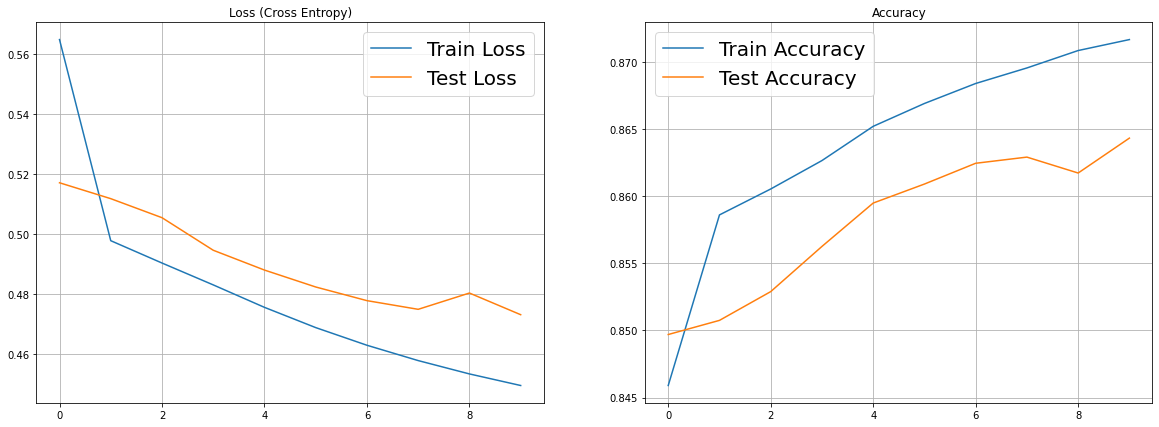

In [47]:
NUM_EPOCH = 10
criterion = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCH):
    
    criterion = nn.CrossEntropyLoss()

    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()


    for x_split, y_split in train_sl:
        x_split = x_split.to(DEVICE)
        y_split = y_split.to(DEVICE)

        for train_batch in  torch_utils.dataloader(x_split, y_split, BATCH_SIZE):


            x, labels = train_batch

            logits = model.forward(x)
            prediction = torch.argmax(logits, 1)
            loss = criterion(logits, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            acc = torch_utils.calculate_accuracy(prediction, labels)
            train_loss_meter.update(loss)
            train_accuracy_meter.update(acc)


    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)

    for x_split, y_split in test_sl:
        x_split = x_split.to(DEVICE)
        y_split = y_split.to(DEVICE)

        for test_batch in torch_utils.dataloader(x_split, y_split, BATCH_SIZE):
            x, labels = test_batch

            with torch.no_grad():
                logits = model.forward(x)
                prediction = torch.argmax(logits, 1)
                loss = criterion(logits, labels)

            acc = torch_utils.calculate_accuracy(prediction, labels)
            test_loss_meter.update(loss)
            test_accuracy_meter.update(acc)

    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)


    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)

    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)

    plt.show()

In [48]:
test_accuracy_meter.avg

tensor(0.8643, device='cuda:0')

In [129]:
test_accuracy_meter.avg

tensor(0.8833, device='cuda:0')